# Testing notebook for nifty fit on atmosphere TODs directly (no image)

# Try to add a nifty model for sampling the input map

numpy version: 2.1.1


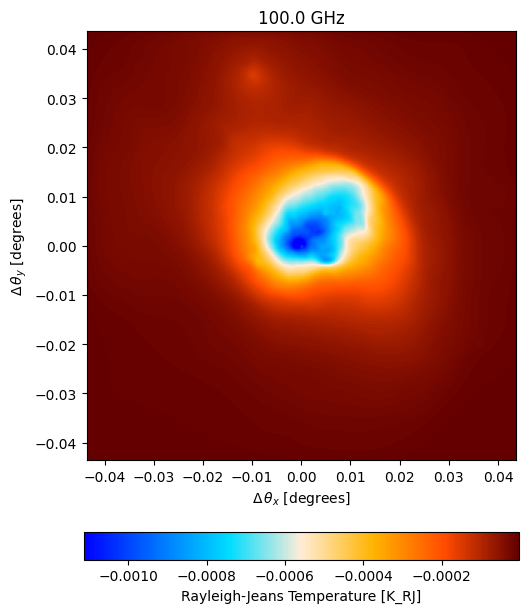

In [1]:
import numpy as np
print(f"numpy version: {np.__version__}")
import matplotlib.pyplot as plt
import maria
import sys
import os

# Relative import of sample_maps for now
sys.path.append(os.path.abspath('python'))
import mapsampling_jax
from mapsampling_jax import sample_maps

map_filename = maria.io.fetch("maps/cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

input_map.to(units="K_RJ").plot()

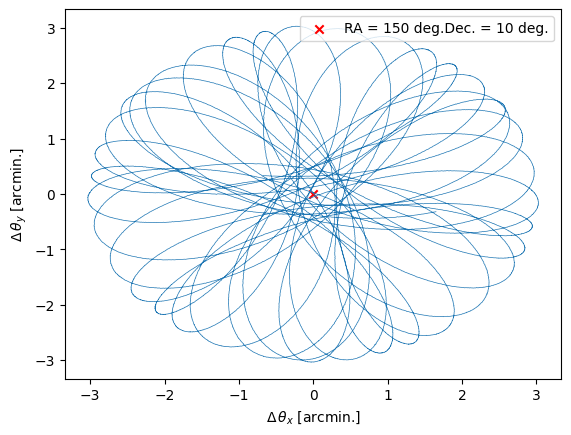

In [2]:
#load the map into maria
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                      duration=600, # integration time in seconds
                    # duration=60,
                    #   duration=300, # integration time in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

plan.plot()

2024-10-25 13:09:35.733 INFO: Initialized base in 1516 ms.
Building atmosphere: 100%|██████████| 6/6 [00:04<00:00,  1.22it/s]
2024-10-25 13:09:41.995 INFO: Initialized atmosphere in 6247 ms.
Sampling map (m2/f093):   0%|          | 0/1 [00:00<?, ?it/s]

u[:, m] maria: [-0.02730539 -0.07902115 -0.1260865  -0.15962622 -0.1827697  -0.19894824
 -0.21028489 -0.21811236 -0.22337614 -0.22680863 -0.22897421 -0.23027142
 -0.23095645 -0.23116996 -0.23095645 -0.23027142 -0.22897421 -0.22680863
 -0.22337614 -0.21811236 -0.21028489 -0.19894824 -0.1827697  -0.15962622
 -0.1260865  -0.07902115 -0.02730539]


Generating noise: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


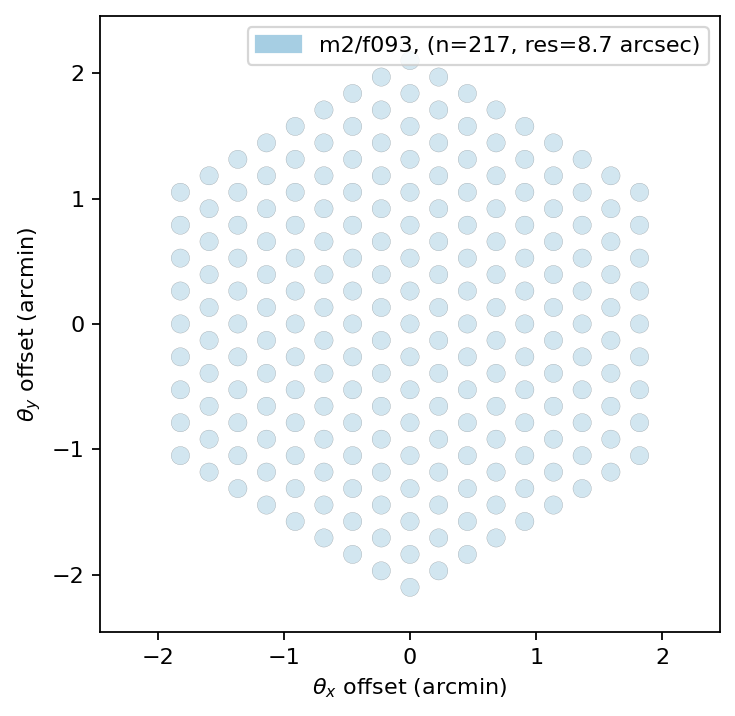

In [3]:
# instrument = maria.get_instrument('MUSTANG-2')
instrument = mapsampling_jax.instrument
instrument.plot()

sim_truthmap = maria.Simulation(instrument, 
                                plan=plan,
                                site="llano_de_chajnantor", 
                                map=input_map,
                                # noise=False,
                                atmosphere="2d",
                                # cmb="generate",
                                )

tod_truthmap = sim_truthmap.run()

In [4]:
dx, dy = sim_truthmap.coords.offsets(frame=sim_truthmap.map.frame, center=sim_truthmap.map.center)
dx = dx.compute()
dy = dy.compute()

dx

array([[-1.96642112e-04, -1.92916011e-04, -1.90195252e-04, ...,
         4.73280310e-04,  4.76616324e-04,  4.80260439e-04],
       [-2.45761197e-04, -2.42035245e-04, -2.39314568e-04, ...,
         4.27933706e-04,  4.31269550e-04,  4.34913487e-04],
       [-1.21451920e-04, -1.17725853e-04, -1.15005113e-04, ...,
         5.49158311e-04,  5.52494302e-04,  5.56138392e-04],
       ...,
       [ 1.21120398e-04,  1.24847730e-04,  1.27569155e-04, ...,
         7.60175084e-04,  7.63512489e-04,  7.67158054e-04],
       [-4.05210947e-04, -4.01483376e-04, -3.98761821e-04, ...,
         2.29029068e-04,  2.32366639e-04,  2.36012378e-04],
       [-7.46021443e-04, -7.42295436e-04, -7.39574729e-04, ...,
        -7.26809191e-05, -6.93451038e-05, -6.57011959e-05]])

Running mapper (m2/f093): 100%|██████████| 1/1 [00:05<00:00,  5.72s/it]


mapdata_truth shape: (1, 1, 1000, 1000)
mapdata_truth mean: -8.726028151723567e-05


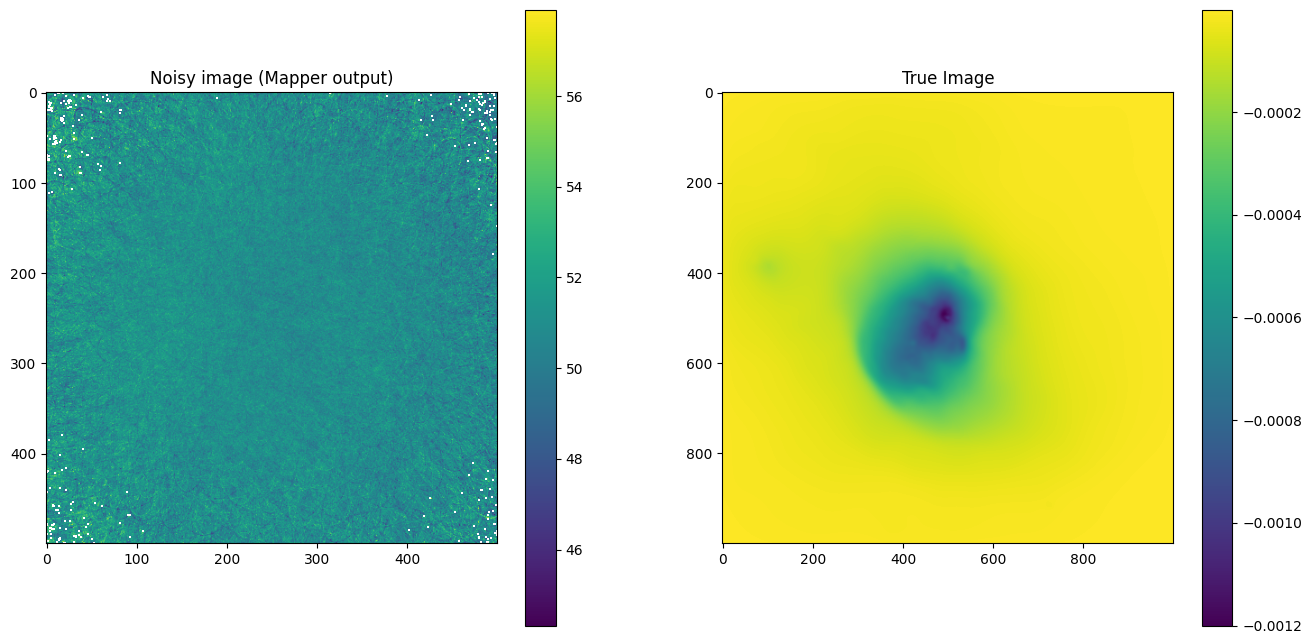

In [5]:
from maria.map.mappers import BinMapper

# Run mapper without any filtering to get noisy mimge
mapper_truthmap = BinMapper(center=(150, 10), frame="ra_dec", width=0.1, height=0.1, resolution=2e-4, map_postprocessing={"gaussian_filter": {"sigma": 0}} )
mapper_truthmap.add_tods(tod_truthmap)
output_truthmap = mapper_truthmap.run()

mapdata_truth = np.float64(sim_truthmap.map.data)
mapdata_truth = np.nan_to_num(mapdata_truth, nan=np.nanmean(mapdata_truth)) # replace nan value by img mean

print("mapdata_truth shape:", mapdata_truth.shape)
print("mapdata_truth mean:", mapdata_truth.mean())

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(output_truthmap.data[0].T)
fig.colorbar(im0)
axes[0].title.set_text("Noisy image (Mapper output)")

im1 = axes[1].imshow(mapdata_truth[0, 0])
fig.colorbar(im1)
axes[1].title.set_text("True Image")

plt.show()

# Re-implement map sampling in JAX for nifty response function:

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import jax
from jax import random
import jax.numpy as jnp

import nifty8.re as jft
import matplotlib.pyplot as plt

import numpy as np

from functools import reduce
from operator import or_

seed = 42
key = random.PRNGKey(seed)

2024-10-25 13:09:56.283 INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-10-25 13:09:56.285 INFO: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


# Test TOD agreement:

In [7]:
import jax
import jax.numpy as jnp

# Sample 2D data (shape: (4, 4))
data = jnp.array([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12],
    [13, 14, 15, 16]
])

# Original line of code
data_padded = jnp.column_stack([data[:,0], data, data[:, -1]])

print("Original Data:")
print(data)

print("\nData after column_stack (with first and last columns repeated):")
print(data_padded)


Original Data:
[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]

Data after column_stack (with first and last columns repeated):
[[ 1  1  2  3  4  4]
 [ 5  5  6  7  8  8]
 [ 9  9 10 11 12 12]
 [13 13 14 15 16 16]]


In [8]:
import jax
import jax.numpy as jnp

# Sample 3D data (shape: (n, 4, 4)), where n = 2 in this example
data = jnp.array([
    [
        [1, 2, 3, 4],
        [5, 6, 7, 8],
        [9, 10, 11, 12],
        [13, 14, 15, 16]
    ],
    [
        [17, 18, 19, 20],
        [21, 22, 23, 24],
        [25, 26, 27, 28],
        [29, 30, 31, 32]
    ]
])

# Define the function to apply column stacking to a single 2D slice
def pad_2d_slice(data_2d):
    return jnp.column_stack([data_2d[:, 0], data_2d, data_2d[:, -1]])

# Use vmap to vectorize the padding function across the first axis (n)
data_padded = jax.vmap(pad_2d_slice)(data)

print("Original Data (3D):")
print(data)

print("\nData after column_stack (with first and last columns repeated):")
print(data_padded)


Original Data (3D):
[[[ 1  2  3  4]
  [ 5  6  7  8]
  [ 9 10 11 12]
  [13 14 15 16]]

 [[17 18 19 20]
  [21 22 23 24]
  [25 26 27 28]
  [29 30 31 32]]]

Data after column_stack (with first and last columns repeated):
[[[ 1  1  2  3  4  4]
  [ 5  5  6  7  8  8]
  [ 9  9 10 11 12 12]
  [13 13 14 15 16 16]]

 [[17 17 18 19 20 20]
  [21 21 22 23 24 24]
  [25 25 26 27 28 28]
  [29 29 30 31 32 32]]]


jax_conv input shapes: (1, 1000, 1000) (27, 1)
jax_conv output shape: (1000, 1000)


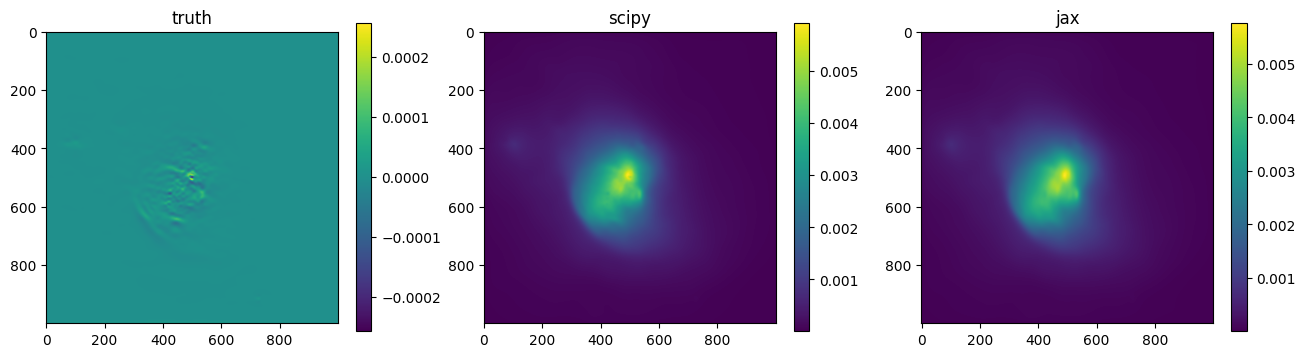

In [13]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np

img_truth = mapdata_truth[0]

array_maria = np.array([
    -0.02730539, -0.07902115, -0.1260865, -0.15962622, -0.1827697, -0.19894824,
    -0.21028489, -0.21811236, -0.22337614, -0.22680863, -0.22897421, -0.23027142,
    -0.23095645, -0.23116996, -0.23095645, -0.23027142, -0.22897421, -0.22680863,
    -0.22337614, -0.21811236, -0.21028489, -0.19894824, -0.1827697, -0.15962622,
    -0.1260865, -0.07902115, -0.02730539
])

array_jax = np.array([
    0.02730539, 0.07902115, 0.1260865, 0.15962622, 0.1827697, 0.19894824,
    0.21028489, 0.21811236, 0.22337614, 0.22680863, 0.22897421, 0.23027142,
    0.23095645, 0.23116996, 0.23095645, 0.23027142, 0.22897421, 0.22680863,
    0.22337614, 0.21811236, 0.21028489, 0.19894824, 0.1827697, 0.15962622,
    0.1260865, 0.07902115, 0.02730539
])

import scipy as sp
sp_conv = sp.ndimage.convolve1d(img_truth, array_maria, axis=0)[0]

# jax_kernel = array_jax[:, None]
jax_kernel = array_maria[:, None]

def pad_2d_slice(data_2d):
    data_2d = jax.numpy.column_stack([data_2d[:, 0], data_2d, data_2d[:, -1]]) # axis=1
    data_2d = jax.numpy.vstack([data_2d[0], data_2d, data_2d[-1]]) # axis=0    
    return data_2d

print("jax_conv input shapes:", img_truth.shape, jax_kernel.shape)
jax_conv = jax.scipy.signal.convolve(img_truth[0], jax_kernel, mode='same', precision='high')
print("jax_conv output shape:", jax_conv.shape)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Display the Gaussian image using imshow
im0 = axes[0].imshow(sp_conv - jax_conv)
axes[0].title.set_text('truth')
fig.colorbar(im0)
im1 = axes[1].imshow(sp_conv)
axes[1].title.set_text('scipy')
fig.colorbar(im1)
im2 = axes[2].imshow(jax_conv)
axes[2].title.set_text('jax')
fig.colorbar(im2)

plt.show()

In [10]:
jax_tods_map, sp_conv, jax_conv = sample_maps(mapdata_truth, dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(jax_tods_map[i], label=i)

    tods_map = np.float64(tod_truthmap.get_field('map').compute())
    im1 = axes[1].plot(tods_map[i], label=i)

    im2 = axes[2].plot(jax_tods_map[i] - tods_map[i], label=i)
    
axes[0].title.set_text(f'JAX map, TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'True map, TOD0-{i}')
axes[1].legend()
axes[2].title.set_text(f'jax map - true map, TOD0-{i}')
axes[2].legend()

plt.show()

MARKER: pre-TRJ
sim_truthmap.shape (1, 1, 1000, 1000)
TRJ shape: (64, 1, 1000, 1000)
TRJ shape after reshape: (1, 64, 1000, 1000)
nu_passband shape: (64,)
construct_beam_filter inputs: 4.241302394573353e-05 1.5208799101878587e-06
F shape: (27, 27)
u, s, v shapes: (27, 27) (27,) (27, 27)
data.shape (1, 1000, 1000)
jax u[:, m]: [0.02730539 0.07902115 0.1260865  0.15962622 0.1827697  0.19894824
 0.21028489 0.21811236 0.22337614 0.22680863 0.22897421 0.23027142
 0.23095645 0.23116996 0.23095645 0.23027142 0.22897421 0.22680863
 0.22337614 0.21811236 0.21028489 0.19894824 0.1827697  0.15962622
 0.1260865  0.07902115 0.02730539]
filtered_power_map shape: (1, 1000, 1000)


ValueError: too many values to unpack (expected 3)

In [11]:
sp_conv.shape

(1, 1000, 1000)

In [12]:
jax_conv.shape

(1000, 1000)

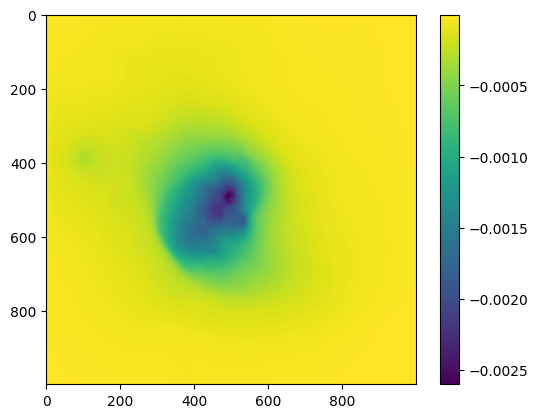

In [13]:
plt.imshow(sp_conv[0])
plt.colorbar()

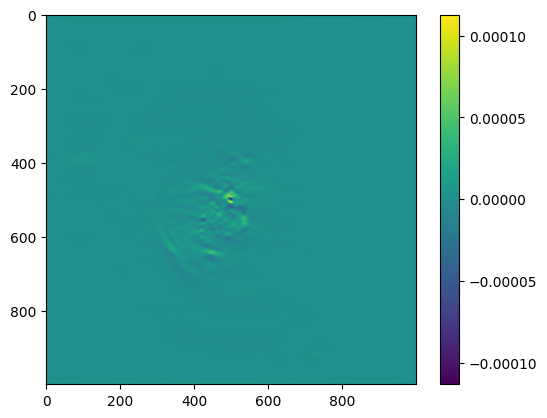

In [14]:
plt.imshow(jax_conv - sp_conv[0])
plt.colorbar()